In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

# required due to an issue with CUDA on Windows (https://github.com/pytorch/pytorch/issues/17108)
# torch.cuda.current_device()

# for loading MNIST data
from torchvision import transforms, datasets

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# if cuda device is available then run model on gpu
if torch.cuda.is_available():
    cuda_flag=True
else:
    cuda_flag=False

### Setting up data loader

Data loaders make our lives easier by providing an easy interface to access data in batches as well shuffle the data so that no bias due to unfortunate grouping of examples creep in. This also helps in stabilising the training.

Using torchvision's datasets module we can directly download MNIST dataset and transform it to give us images in the form of Tensors.

In [4]:
batch_size=64

train_loader = torch.utils.data.DataLoader(
                datasets.MNIST('./dataset/', train=True, download=True, transform=transforms.ToTensor()), 
                batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
                datasets.MNIST('./dataset/', train=False, download=True, transform=transforms.ToTensor()),
                batch_size=batch_size)

### Class Definition for the Model

We define a simple (yet good enough for our small problem) architecture of two convolutional layers followed by two fully connected layers and use ReLU activation. We also add max pooling in between convolutional layers. Lastly we return a softmax of output vector.

In [6]:
class clf_mnist(nn.Module):
    def __init__(self, num_classes):
        super(clf_mnist, self).__init__()
        # Since images are black and white we will have only 1 input channel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(32*7*7,256)
        self.fc2 = nn.Linear(256,num_classes)
        
        self.pool = nn.MaxPool2d(kernel_size=2)
    
    def forward(self,x):
        # 1*28*28 -> 16*28*28
        x = torch.relu(self.conv1(x))
        # 16*28*28 -> 16*14*14
        x = self.pool(x)
        
        # 16*14*14 -> 32*14*14
        x = torch.relu(self.conv2(x))
        # 32*14*14 -> 32*7*7
        x = self.pool(x)
        
        # flatten the image to pass it through fully connected layers
        x = x.view(-1,32*7*7)
        x = torch.relu(self.fc1(x))
        # softmax gives probabilistic interpretation to class scores
        x = torch.softmax(self.fc2(x),1)
        return x

### Training phase

In [7]:
# instantiate the model
model = clf_mnist(10)
# move the model to gpu if gpu computation is available
if cuda_flag:
    model = model.cuda()

In [8]:
# define optimizer to update the model parameters
opt = optim.Adam(model.parameters())

# define loss function
crit = nn.CrossEntropyLoss()

In [9]:
epochs = 10
loss_history = []

In [10]:
for epoch in range(epochs):
    train_loss=0
    accuracy = 0
    
    # set the model to train phase
    model.train()
    
    # iterate over dataset
    for x,y in train_loader:
        
        # zero_grad to ensure no unaccounted calculation creeps in while calculating gradients
        opt.zero_grad()
        
        # move data to gpu if cuda_flag is set
        if cuda_flag:
            x,y = x.cuda(), y.cuda()
        
        # forward propogation and loss computation
        y_pred = model(x)
        loss = crit(y_pred,y)
        train_loss+=loss.item()
        
        # backpropogate gradients
        loss.backward()
        
        # update weights
        opt.step()

        # find class with maximum probability for each example and calculate accuracy
        _, predicted = torch.max(y_pred, 1)
        accuracy += (predicted == y).sum().item()
    
    accuracy = accuracy*100/(batch_size*len(train_loader))
    print ("Epoch:{}\t Train Loss:{:.6}\t Train Accuracy:{:.4}".format(epoch,train_loss,accuracy))
    loss_history.append(train_loss)

Epoch:0	 Train Loss:1512.47	 Train Accuracy:85.42
Epoch:1	 Train Loss:1397.68	 Train Accuracy:97.21
Epoch:2	 Train Loss:1389.32	 Train Accuracy:98.03
Epoch:3	 Train Loss:1385.93	 Train Accuracy:98.39
Epoch:4	 Train Loss:1382.86	 Train Accuracy:98.68
Epoch:5	 Train Loss:1381.45	 Train Accuracy:98.83
Epoch:6	 Train Loss:1380.18	 Train Accuracy:98.94
Epoch:7	 Train Loss:1378.96	 Train Accuracy:99.09
Epoch:8	 Train Loss:1378.91	 Train Accuracy:99.07
Epoch:9	 Train Loss:1377.39	 Train Accuracy:99.23


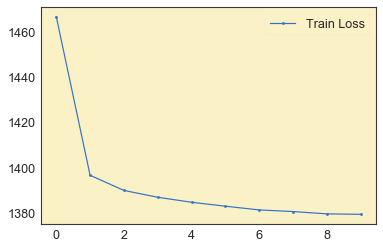

In [17]:
# Plot loss function to see how the training proceeded, useful while debugging models
plt.plot(loss_history, ".-", label="Train Loss")
plt.legend()
plt.show()

In [18]:
# save your model
torch.save(model.state_dict(),"./classifier.pth")

### Testing Phase

In [ ]:
# load the model
model = clf_mnist(10)
model.load_state_dict(torch.load("./classifier.pth"))
# set the model to eval phase
model.eval()
if cuda_flag:
    model = model.cuda()

In [13]:
accuracy = 0
num_examples = 0
for x,y in (test_loader):
    if cuda_flag:
        x,y = x.cuda(), y.cuda()
    _, predicted = torch.max(model(x).detach(), 1) # detach to avoid accidental gradient backpropogation
    num_examples+=len(predicted)
    correct = (predicted == y).sum()
    accuracy += correct.item() 
    
print ("Test Accuracy:",accuracy/num_examples)

Test Accuracy: 0.9887


Our model performs great on the test data! Yippee!

However what if it didn't perform well. How should one debug it?
#### Visualising the classification performance
Just getting the accuracy of the model doesn't give us insight into what exactly the model is doing wrong so that we can improve it. For getting a better understanding of model's classification performance we will use a confusion matrix which allows us a more fine grained analysis of model's performance.

In [21]:
# firstly we collect the individual predictions and their true label
test_predictions = []
test_gold = []
for x,y in (test_loader):
    if cuda_flag:
        x = x.cuda()
    _, predicted = torch.max(model(x).detach(), 1) # detach to avoid accidental gradient backpropogation
    test_predictions.append(predicted.cpu().numpy())
    test_gold.append(y.numpy())

test_predictions = np.concatenate(test_predictions)
test_gold = np.concatenate(test_gold)

In [19]:
# load sklearn's module for confusion matrix
from sklearn.metrics import confusion_matrix

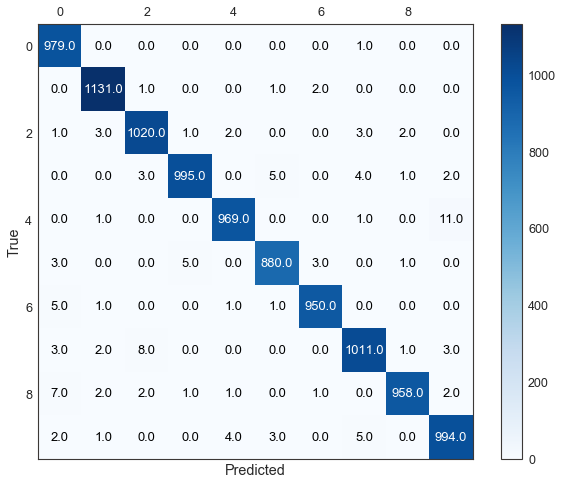

In [66]:
# generate confusion matrix
conf_mat = confusion_matrix(test_gold, test_predictions)

# plot the matrix
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap="Blues")

# add text to the plot
for (i, j), z in np.ndenumerate(conf_mat):
    ax.text(j, i, '{:0.1f}'.format(z), fontsize=13, ha='center', va='center', color="white" if conf_mat[i, j] > 100 else "black")

# add colorbar for reference
fig.colorbar(cax)

# add labels to plot
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

The intensity of colors concentrated on the diagonal shows that our model is very accurate. You may find more detailed confusion matrix plotting techniques [here](https://medium.com/@deepanshujindal.99/how-to-plot-wholesome-confusion-matrix-40134fd402a8) .